In [17]:
import pandas as pd
import glob
import os 
import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import glob
import random

from tqdm import tqdm

In [2]:
tr = pd.read_csv("../data/train.csv")
trl = pd.read_csv("../data/train_localizers.csv")


In [3]:
import multiprocessing
import os
import time

In [47]:
def getsz(uid):
    files = list(glob.glob(f"../data/series/{uid}/*.dcm"))
    img = pydicom.dcmread(files[0])
    if len(img.pixel_array.shape) == 3:
        return uid,img.pixel_array.shape[1],img.pixel_array.shape[2]
    
    return uid,img.pixel_array.shape[0],img.pixel_array.shape[1]

In [48]:

uids = list(tr["SeriesInstanceUID"])

with multiprocessing.Pool(processes=16) as pool:

    data = pool.map(getsz, uids)


/home/paradox/Desktop/ai/ai-env/lib/python3.12/site-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(


In [49]:
szdf = pd.DataFrame({ "SeriesInstanceUID": [s[0] for s in data]
                    , "height": [s[1] for s in data]
                    , "width": [s[2] for s in data]
                    }
                   )

In [50]:
szdf.iloc[:,1:].describe()

,height,width
count,4405.000000,4405.000000
mean,507.320091,494.674461
std,113.190796,113.196997
min,192.000000,176.000000
25%,512.000000,512.000000
50%,512.000000,512.000000
75%,512.000000,512.000000
max,1024.000000,1024.000000


In [58]:
import numpy as np

In [65]:
def viewinstance(uid,level, around):
    files = list(glob.glob(f"../data/series/{uid}/*.dcm"))

    lvls = []
    for f in files:
        lvls.append((int(pydicom.dcmread(f).InstanceNumber),f))

    lvls = sorted(lvls)
    print(len(lvls))

    lvls = [*filter(lambda lvl:  abs(lvl[0] - level) <= around, lvls)]
    
    for lvl,f in lvls:
        img = pydicom.dcmread(f).pixel_array
        print(img.shape,np.min(img), np.max(img),img.dtype)
        fig, ax = plt.subplots()
        if len(img.shape) > 2:
            continue
        ax.imshow(img)
        # rect = patches.Rectangle((c["x"]-10, c["y"]-10), 20, 20, linewidth=1, edgecolor='r', facecolor='none')
        # ax.add_patch(rect)
        plt.show()
    
    

188
(512, 512) 0 362 int16


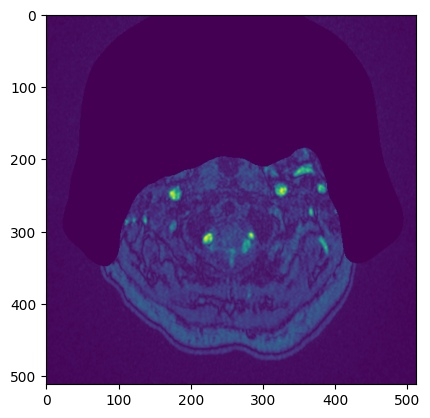

In [69]:
viewinstance(szdf.iloc[0,0], 0, 1)

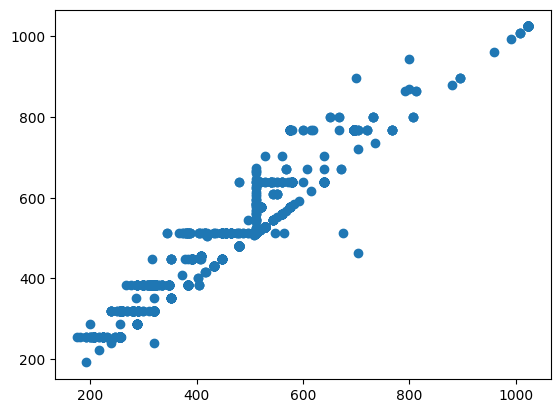

In [52]:
plt.scatter(x=szdf["width"],y=szdf["height"])
# plt.



1. Filter the uids that we don't wanna use
2. Create 5-Folds
3. create volumes

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import ast
import pydicom

import multiprocessing

from pathlib import Path
import os
import pydicom
import cv2

/home/paradox/Desktop/ai/ai-env/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.sparse import csr_matrix, issparse


In [2]:
train_df = pd.read_csv("../data/train.csv")
label_df = pd.read_csv("../data/train_localizers.csv")
mf_dicom_uids = pd.read_csv("../data/multiframe_dicoms.csv")

In [3]:
ignore_uids = [
    "1.2.826.0.1.3680043.8.498.11145695452143851764832708867797988068",
    "1.2.826.0.1.3680043.8.498.35204126697881966597435252550544407444",
    "1.2.826.0.1.3680043.8.498.87480891990277582946346790136781912242"
] + list(mf_dicom_uids["SeriesInstanceUID"])
train_df = train_df[~train_df["SeriesInstanceUID"].isin(ignore_uids)].reset_index(drop=True)

In [4]:
train_df["fold_id"] = 0

In [5]:
sgkf = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)

for i, (train_index, test_index) in enumerate(sgkf.split(train_df["SeriesInstanceUID"], train_df["Aneurysm Present"])):
    train_df.loc[test_index, "fold_id"] =  i 

In [6]:
label_df["x"] = [s['x'] for s in list(label_df["coordinates"].map(ast.literal_eval)) ]
label_df["y"] = [s['y'] for s in list(label_df["coordinates"].map(ast.literal_eval)) ]
label_df["z"] = -1



In [7]:

# uid_t = "1.2.826.0.1.3680043.8.498.10134365079002163886508836892471866754"

In [8]:
def calculate_z_coord():
    for idx,rowdf in label_df.iterrows():
        uid,f = rowdf["SeriesInstanceUID"],rowdf["SOPInstanceUID"]

        label_df.loc[idx,'z'] = int(pydicom.dcmread(f"../data/series/{uid}/{f}.dcm").InstanceNumber) - 1
        
    

In [9]:
calculate_z_coord()

In [10]:
del label_df["coordinates"]

In [11]:
label_df.head()

,SeriesInstanceUID,SOPInstanceUID,location,x,y,z
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,Other Posterior Circulation,258.362119,261.359900,162
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,Right Middle Cerebral Artery,194.872531,178.326750,453
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,Right Middle Cerebral Artery,189.239799,209.191849,112
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,Right Infraclinoid Internal Carotid Artery,208.280505,229.789621,177
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,Anterior Communicating Artery,249.867456,220.623045,46


In [12]:
def apply_dicom_windowing(img: np.ndarray, window_center: float, window_width: float) -> np.ndarray:
    """Apply DICOM windowing"""
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    img = (img - img_min) / (img_max - img_min + 1e-7)
    return (img * 255).astype(np.uint8)

def get_windowing_params(modality: str) -> tuple[float, float]:
    """Get appropriate windowing for different modalities"""
    windows = {
        'CT': (40, 80),
        'CTA': (50, 350),
        'MRA': (600, 1200),
        'MRI': (40, 80),
    }
    return windows.get(modality, (40, 80))



In [13]:
IMG_SIZE = 512
FACTOR = 3

In [14]:
# mf_dicom_uids.iloc[0,0]

In [15]:
def process_slice(img,ds):
    modality = getattr(ds, 'Modality', 'CT')
    
    # Apply rescale if available
    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
        img = img * ds.RescaleSlope + ds.RescaleIntercept
        
    window_center, window_width = get_windowing_params(modality)
    img = apply_dicom_windowing(img, window_center, window_width)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img



def process_dicom_series(uid: str) -> tuple[np.ndarray, dict]:
    """Process a DICOM series and extract metadata"""
    series_path = Path(f"../data/series/{uid}")
    
    # Find all DICOM files
    all_filepaths = []
    for root, _, files in os.walk(series_path):
        for file in files:
            if file.endswith('.dcm'):
                all_filepaths.append(os.path.join(root, file))
    all_filepaths.sort()
    
    if len(all_filepaths) == 0:
        print(f"No DCM files found for {uid}")
        return
        
    # Process DICOM files
    slices = []
    modality = None
    instance_numbers = []
    
    for i, filepath in enumerate(all_filepaths):
        ds = pydicom.dcmread(filepath, force=True)
        
        # print(ds.InstanceNumber)
        img = ds.pixel_array.astype(np.float32)
        if img.ndim == 3:
            if img.shape[-1] == 3:
                imgs = [cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float32)]
                # return
            else:
                print(f"multiframe: {img.shape}")
                imgs = []
                for i in range(img.shape[0]):
                    imgs.append(img[i, :, :])

        else:
            # return
            imgs = [img]
            
        for img in imgs:
            if hasattr(ds, "InstanceNumber"):
                instance_numbers.append(ds.InstanceNumber)
            
            if hasattr(ds, "ImagePositionPatient"):
                slices.append((ds.ImagePositionPatient[-1],process_slice(img,ds)))
            elif hasattr(ds, "InstanceNumber"):
                slices.append((int(ds.InstanceNumber),process_slice(img,ds)))
            else:
                slices.append((0,process_slice(img,ds)))


    instance_numbers = sorted(instance_numbers)
    start_instance_number = instance_numbers[0] - 1


    slices = sorted(slices, key = lambda x: x[0])
    
    volume = np.array([slice[-1] for slice in slices])

    selected_idxs = [*range(0,volume.shape[0],FACTOR)]

    uid_label_df = label_df[label_df["SeriesInstanceUID"] == uid]

    required_idxs = [idx - start_instance_number for idx in list(uid_label_df["z"])]
    
    if len(required_idxs) != 0:
        final_idxs = sorted(list(set(selected_idxs).union(required_idxs)))
    else:
        final_idxs = sorted(selected_idxs)

    if len(required_idxs) != 0:
        print("required")
        mapped_idxs = [final_idxs.index(idx) for idx in required_idxs]
        print(mapped_idxs)
        label_df.loc[label_df["SeriesInstanceUID"] == uid,'z'] = mapped_idxs


    # np.savez(f"../data/processed/{uid}.npz", vol=volume[final_idxs])
    return volume[final_idxs]
        

In [16]:
fdf = pd.read_csv("../data/processed/label_df.csv")

In [17]:
uid = label_df.head().iloc[4,0]

In [18]:
vol = process_dicom_series(uid)

required
[16]


In [19]:
print(vol.shape)


(29, 512, 512)


In [20]:
fdf[fdf["SeriesInstanceUID"] == uid]

,SeriesInstanceUID,SOPInstanceUID,location,x,y,z
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,Anterior Communicating Artery,249.867456,220.623045,16


In [21]:
label_df[label_df["SeriesInstanceUID"] == uid]

,SeriesInstanceUID,SOPInstanceUID,location,x,y,z
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,Anterior Communicating Artery,249.867456,220.623045,16


In [21]:
from tqdm import tqdm

In [22]:


# # Assume train_df and process_dicom_series are defined elsewhere
# # For example:
# # train_df = pd.read_csv("path/to/your/train.csv")
# # def process_dicom_series(uid):
# #     # Your actual processing logic for a single series UID
# #     # ...
# #     return np.random.rand(10, 10) # Placeholder for the processed volume


# # 1. Define a worker function
# # This function contains the logic that was inside your for-loop.
# # It takes one item (a UID) and performs the full task for it.
# def process_and_save(uid):
#     """Processes a single DICOM series and saves it to a .npz file."""
#     try:
#         vol, mapped_idx = process_dicom_series(uid)
#         np.savez_compressed(f"../data/processed/{uid}.npz", vol=vol) # Use savez_compressed for smaller files
#         return {"uid": uid, "mapped_idx": mapped_idx}, None # Return UID on success
#     except Exception as e:
#         return {"uid": uid, "mapped_idx": []}, e # Return UID and the error if something fails

# # Get the list of unique UIDs to process
# uids_to_process = train_df["SeriesInstanceUID"].unique()
# total_uids = len(uids_to_process)

# print(f"Starting processing for {total_uids} UIDs...")

# # 2. Set up the multiprocessing Pool
# # os.cpu_count() is a good default for the number of parallel processes.
# with multiprocessing.Pool(processes=16) as pool:
    
#     # 3. Use imap_unordered with tqdm for a progress bar
#     # imap_unordered is efficient because it yields results as they finish.
#     # tqdm wraps the iterator to show progress.
#     results = list(tqdm(pool.imap_unordered(process_and_save, uids_to_process), total=total_uids))

# print("\nProcessing complete.")



In [23]:
# for uid in tqdm(train_df["SeriesInstanceUID"].unique()[:10]):
#     process_dicom_series(uid)
#     # break

In [24]:
# for r in results:
#     data = r[0]
#     if len(data["mapped_idx"]) != 0:
#         label_df.loc[label_df["SeriesInstanceUID"] == data["uid"],'z'] = data["mapped_idx"]

In [25]:
label_df.head()

,SeriesInstanceUID,SOPInstanceUID,location,x,y,z
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,Other Posterior Circulation,258.362119,261.359900,162
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,Right Middle Cerebral Artery,194.872531,178.326750,453
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,Right Middle Cerebral Artery,189.239799,209.191849,112
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,Right Infraclinoid Internal Carotid Artery,208.280505,229.789621,177
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,Anterior Communicating Artery,249.867456,220.623045,46


In [26]:
# label_df.to_csv("../data/processed/label_df.csv", index=False)
# train_df.to_csv("../data/processed/train_df.csv", index=False)

In [38]:
import matplotlib.pyplot as plt

In [45]:
fdf = pd.read_csv("../data/processed/label_df.csv")


In [101]:
fdf.head(1)

,SeriesInstanceUID,SOPInstanceUID,location,x,y,z
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,Other Posterior Circulation,258.362119,261.3599,54


In [54]:
idx = 0
uid = label_df.iloc[idx,0]
sopuid = label_df.iloc[idx,1]

ds = pydicom.dcmread(f"../data/series/{uid}/{sopuid}.dcm")
imgslice = process_slice(ds.pixel_array, ds)
vol = np.load(f"../data/processed/{uid}.npz")["vol"]

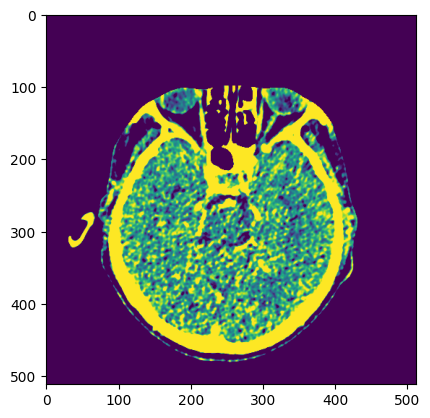

In [56]:
plt.imshow(imgslice)

In [61]:
imgslice

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(512, 512), dtype=uint8)

In [104]:
nvol = process_dicom_series(uid)

required


In [64]:
vol[54].min(), vol[54].max()

(np.uint8(0), np.uint8(255))

In [106]:
np.abs(vol[54] - nvol[162]).sum()
# np.allclose(imgslice,vol[54], atol=1)

np.uint64(0)

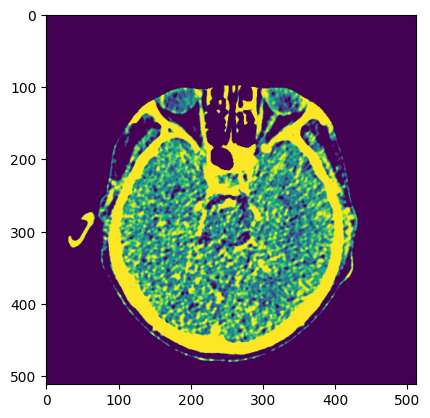

In [49]:
plt.imshow(vol[54])

In [48]:
fdf[fdf["SeriesInstanceUID"] == uid]

,SeriesInstanceUID,SOPInstanceUID,location,x,y,z
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,Other Posterior Circulation,258.362119,261.3599,54


In [9]:
import pandas as pd

In [10]:
df = pd.read_csv("../data/processed/train_df.csv")
labeldf = pd.read_csv("../data/processed/label_df.csv")

In [11]:
df.iloc[0]["Aneurysm Present"] == 0

np.True_

In [13]:
labels = sorted(labeldf.location.unique())

In [14]:
labels_to_idx = {label: idx for idx, label in enumerate(labels)}


In [16]:
df.fold_id.value_counts()

fold_id
4    852
0    852
3    852
2    852
1    852
Name: count, dtype: int64

In [15]:
labels_to_idx

{'Anterior Communicating Artery': 0,
 'Basilar Tip': 1,
 'Left Anterior Cerebral Artery': 2,
 'Left Infraclinoid Internal Carotid Artery': 3,
 'Left Middle Cerebral Artery': 4,
 'Left Posterior Communicating Artery': 5,
 'Left Supraclinoid Internal Carotid Artery': 6,
 'Other Posterior Circulation': 7,
 'Right Anterior Cerebral Artery': 8,
 'Right Infraclinoid Internal Carotid Artery': 9,
 'Right Middle Cerebral Artery': 10,
 'Right Posterior Communicating Artery': 11,
 'Right Supraclinoid Internal Carotid Artery': 12}

In [12]:
import numpy as np

In [7]:
vol = np.load("../data/processed/1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647.npz")["vol"]

In [8]:
vol.min(), vol.max()

(np.uint8(0), np.uint8(255))

In [13]:
labels = np.load("../labels.npz")

In [15]:
labels["loc_probs"]

array([[7.7536441e-14, 1.8871692e-16, 7.7219969e-34, ..., 3.7263039e-14,
        1.3944598e-17, 2.3027832e-10],
       [7.1281448e-02, 3.8684748e-02, 1.2534111e-02, ..., 3.1759672e-02,
        1.2120609e-02, 1.5405468e-02],
       [1.3287560e-14, 1.3916444e-23, 0.0000000e+00, ..., 8.1876243e-21,
        1.0441280e-23, 1.9605383e-20],
       ...,
       [1.2658424e-04, 9.6793274e-06, 3.5416503e-12, ..., 2.5123625e-05,
        1.0904076e-05, 3.1840180e-05],
       [6.5045862e-14, 3.1105178e-21, 0.0000000e+00, ..., 1.3072217e-19,
        2.7670284e-20, 1.6746686e-19],
       [7.1281448e-02, 3.8684748e-02, 9.7588096e-03, ..., 3.1759672e-02,
        1.2120609e-02, 1.5405468e-02]], shape=(852, 13), dtype=float32)

In [1]:
import random
import math
import matplotlib.pyplot as plt

# Items to choose from
items = list(range(200))

# Mean and standard deviation for Gaussian weights
mu = 100
sigma = 50

# Create Gaussian weights (not normalized)
weights = [math.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) for x in items]
# weights

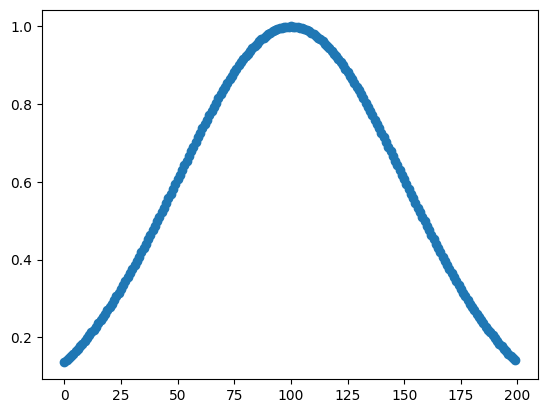

In [2]:
plt.scatter(items, weights)

In [5]:
# [w / sum(weights) for w in weights]

In [ ]:
# Discrete choices
items = np.arange(10)

# Gaussian parameters
mu = 5
sigma = 1.5

# Compute Gaussian-like weights (unnormalized)
weights = np.exp(-((items - mu) ** 2) / (2 * sigma ** 2))

# Normalize weights to sum to 1


In [45]:
import pydicom
import numpy as np
import matplotlib
matplotlib.use('Agg')  
import matplotlib.pyplot as plt
import pandas as pd
import os


def plot_npz(npz_path):
    with np.load(npz_path) as data:
        volume = data['vol']
        print(f"Volume shape: {volume.shape}")
        print(f"Number of slices: {volume.shape[0]}")
        return
        
        for i in range(volume.shape[0]):
            plt.figure(figsize=(8, 8))
            plt.imshow(volume[i], cmap='gray')
            plt.title(f'Slice {i+1}/{volume.shape[0]}')
            plt.axis('off')
            os.makedirs("all_slices_grid", exist_ok=True)
            plt.savefig(f"all_slices_grid/slice_{i+1:03d}.png", dpi=150, bbox_inches='tight')
            plt.close()
            
        print(f"Saved {volume.shape[0]} individual slice images")
        
        num_slices = volume.shape[0]
        cols = int(np.ceil(np.sqrt(num_slices)))
        rows = int(np.ceil(num_slices / cols))
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        fig.suptitle(f'All {num_slices} slices', fontsize=16)
        
        if rows == 1:
            axes = axes.reshape(1, -1)
        elif cols == 1:
            axes = axes.reshape(-1, 1)
            
        for i in range(num_slices):
            row = i // cols
            col = i % cols
            axes[row, col].imshow(volume[i], cmap='gray')
            axes[row, col].set_title(f'Slice {i+1}')
            axes[row, col].axis('off')
            
        for i in range(num_slices, rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')
            
        plt.tight_layout()
        os.makedirs("all_slices_grid", exist_ok=True)
        plt.savefig("all_slices_grid/all_slices_grid.png", dpi=150, bbox_inches='tight')
        plt.close()
        
        print("Saved grid view as 'all_slices_grid.png'")

    #1.2.826.0.1.3680043.8.498.11466016618035234391071120016712127446


In [46]:
train_df = pd.read_csv("../data/train.csv")
label_df = pd.read_csv("../data/train_localizers.csv")
mf_dicom_uids = pd.read_csv("../data/multiframe_dicoms.csv")

In [53]:
uid = train_df[train_df["Modality"] == "CTA"].iloc[2,0]

In [56]:
uid

'1.2.826.0.1.3680043.8.498.10021411248005513321236647460239137906'

In [54]:
train_df[train_df["SeriesInstanceUID"] == uid]

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
6,1.2.826.0.1.3680043.8.498.10021411248005513321...,55,Female,CTA,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
import glob

In [22]:

p = glob.glob(f"../data/series/{uid}/*.dcm")[0]
pydicom.dcmread(p).Modality

'CT'

In [55]:
plot_npz(f"../data/processed/slices/{uid}.npz")

Volume shape: (80, 512, 512)
Number of slices: 80


In [4]:
train_df["Modality"]

NameError: name 'train_df' is not defined

In [15]:
plt.imshow(plt.imread("all_slices_grid/all_slices_grid.png"))
# plt.show()

In [25]:
from tqdm import tqdm

In [26]:
modalities = []

for uid in tqdm(train_df["SeriesInstanceUID"].unique()):
    p = glob.glob(f"../data/series/{uid}/*.dcm")[0]
    modalities.append(pydicom.dcmread(p).Modality)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4405/4405 [00:24<00:00, 180.38it/s]


In [27]:
from collections import Counter

In [28]:
Counter(modalities)

Counter({'MR': 2549, 'CT': 1856})

In [103]:
import pydicom
import numpy as np
import cv2
import pandas as pd

def preprocess_dcm_slice(dcm_path, output_size=(512, 512), window_level=150, window_width=350):
    """
    Reads and preprocesses a single DICOM slice from a CTA or MRA scan.

    For CTA scans, it applies a specific vascular window to highlight arteries.
    For other modalities like MRA, it performs standard min-max normalization.
    The final image is resized and returned as an 8-bit grayscale numpy array.

    Args:
        dcm_path (str): The full path to the .dcm file.
        output_size (tuple): The target dimensions for the output image (width, height).
        window_level (int): The window level (center) for CTA windowing in HU.
        window_width (int): The window width for CTA windowing in HU.

    Returns:
        numpy.ndarray: The preprocessed 8-bit grayscale image, or None if an error occurs.
    """
    try:
        # 1. Read the DICOM file using pydicom
        dcm = pydicom.dcmread(dcm_path)

        # Get the pixel data from the DICOM file
        image = dcm.pixel_array.astype(np.float64)

        # 2. Check if the modality is 'CT' to decide on the processing method
        # The DICOM tag (0008,0060) specifies the modality
        is_ct_scan = 'CT' in dcm.get('Modality', '').upper()

        if is_ct_scan:
            # For CT scans, convert pixel data to Hounsfield Units (HU)
            # using the Rescale Slope and Intercept values from DICOM metadata
            if 'RescaleSlope' in dcm and 'RescaleIntercept' in dcm:
                image = image * dcm.RescaleSlope + dcm.RescaleIntercept

            # Apply the vascular windowing
            lower_bound = window_level - (window_width / 2)
            upper_bound = window_level + (window_width / 2)
            
            # Clip the image to the window range
            image = np.clip(image, lower_bound, upper_bound)
            
            # Normalize the windowed image to a 0-255 scale
            image = ((image - lower_bound) / window_width) * 255.0

        else:
            # 3. For non-CT scans (like MRA), perform standard min-max normalization
            if np.max(image) != np.min(image):
                image = ((image - np.min(image)) / (np.max(image) - np.min(image))) * 255.0

        # Convert the final processed image to an 8-bit unsigned integer format
        image = image.astype(np.uint8)

        # 4. Resize the image to the desired output size
        processed_image = cv2.resize(image, output_size, interpolation=cv2.INTER_LINEAR)

        return processed_image

    except Exception as e:
        print(f"Error processing the file {dcm_path}: {e}")
        return None




def apply_dicom_windowing(img: np.ndarray, window_center: float, window_width: float, preserve_contrast=True) -> np.ndarray:
    img_min = window_center - window_width / 2
    img_max = window_center + window_width / 2
    img_clipped = np.clip(img, img_min, img_max)
    img_normalized = (img_clipped - img_min) / (img_max - img_min + 1e-7)
    img_processed = (img_normalized * 255).astype(np.uint8)
    if preserve_contrast:
        img_processed = cv2.equalizeHist(img_processed)
    return img_processed

def get_windowing_params(modality: str) -> tuple[float, float]:
    """Get appropriate windowing for different modalities"""
    windows = {
        'CT': (40, 80),
        'CTA': (50, 350),
        'MR': (600, 1200),
        'MRA': (600, 1200),
        'MRI': (40, 80),
    }
    return windows.get(modality, (40, 80))


def process_slice(img,ds,modality):
    # modality = getattr(ds, 'Modality', 'CT')

    # Apply rescale if available
    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
        img = img * ds.RescaleSlope + ds.RescaleIntercept

    window_center, window_width = get_windowing_params(modality)
    img = apply_dicom_windowing(img, window_center, window_width)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img


In [104]:
train_df = pd.read_csv("../data/train.csv")
label_df = pd.read_csv("../data/train_localizers.csv")
mf_dicom_uids = pd.read_csv("../data/multiframe_dicoms.csv")

In [105]:
train_df["Modality"].unique()

array(['MRA', 'CTA', 'MRI T2', 'MRI T1post'], dtype=object)

In [106]:
import glob
import matplotlib.pyplot as plt

In [107]:
IMG_SIZE = 512

In [116]:
uid = train_df[train_df["Modality"] == "MRI T2"].iloc[0,0]

dcm_path = glob.glob(f"../data/series/{uid}/*.dcm")[0]
# print(dcm_path)
ds = pydicom.dcmread(dcm_path)
# vol = 

In [119]:
preprocess_dcm_slice(dcm_path).shape

(512, 512, 512)

In [109]:
# plt.imshow()
# 
# preprocess_dcm_slice(dcm_path).shape


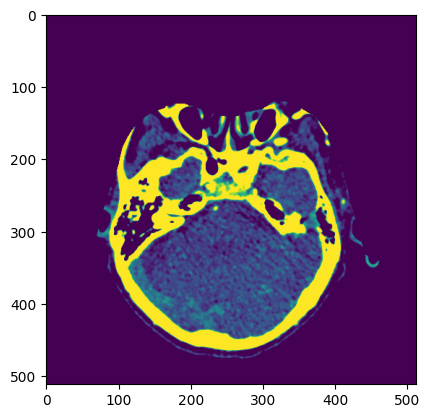

In [114]:

plt.imshow(preprocess_dcm_slice(dcm_path))

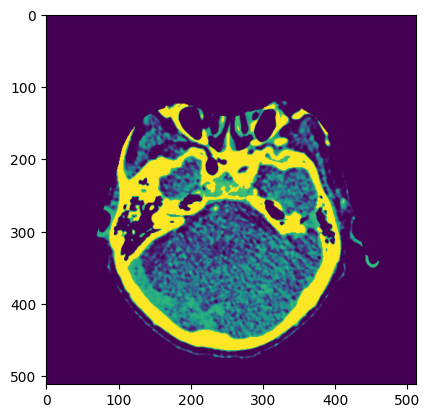

In [113]:
plt.imshow(cv2.equalizeHist(preprocess_dcm_slice(dcm_path)))

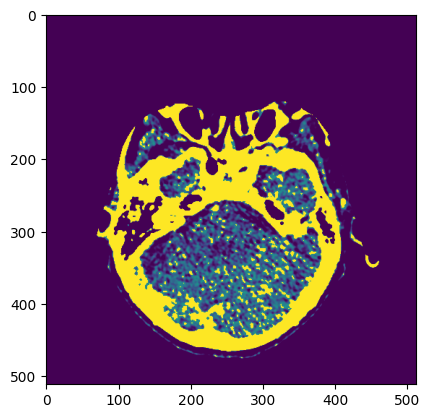

In [111]:
plt.imshow(process_slice(ds.pixel_array, ds, ds.Modality))

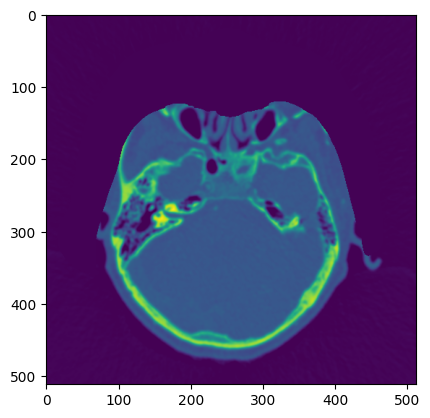

In [112]:

plt.imshow(ds.pixel_array)